In [49]:
import numpy as np
import tensorflow as tf
from curriculum_learning.models.classifier_model import ClassifierModel
from curriculum_learning import utils
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
DATASET_NAME = "eurosat"

N_EPOCHS_CL = 50
BATCH_SIZE = 512

model_fit_base_params = {
    "batch_size": BATCH_SIZE,
    "shuffle": True,
    "verbose": 0,
}
model_fit_1_params = model_fit_base_params | {"epochs": 1}
model_fit_500_params = model_fit_base_params | {"epochs": 500}

loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [65]:
x = []
y = []

ds_1 = tfds.load(DATASET_NAME, split="train", as_supervised=True, shuffle_files=False)
for x_, y_ in ds_1.as_numpy_iterator():
    x.append(x_)
    y.append(y_)
    
# ds_2 = tfds.load(DATASET_NAME, split="test", as_supervised=True, shuffle_files=False)
# for x_, y_ in ds_2.as_numpy_iterator():
#     x.append(x_)
#     y.append(y_)

x = np.array(x, dtype=np.float32) / 255
y = np.array(y, dtype=np.float32)

2024-07-28 13:28:52.132217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

n_classes = len(np.unique(y))
train_size = x_train.shape[0]

x_train_sorted = x_train[np.argsort(y_train)]
y_train_sorted = y_train[np.argsort(y_train)]
_, counts = np.unique(y_train_sorted, return_counts=True)

train_size, len(x_val), len(x_test), train_size + len(x_val) + len(x_test)

(18900, 4050, 4050, 27000)

In [58]:
model = ClassifierModel(output_shape=n_classes, **utils.MODEL_ARCHITECTURE)
model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model(x_train[0:1])
model.load_weights(f"../models/default_model_weights_{DATASET_NAME}.weights.h5")
model_weights = model.get_weights()

In [59]:
def run_experiments_random():        
    model.set_weights(model_weights)

    model.fit(
        x_train_sorted, y_train_sorted, validation_data=(x_val, y_val), **model_fit_500_params,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5, start_from_epoch=35)]
    )

In [60]:
def run_experiments(value_type: str, order_type: utils.OrderType):    
    hist_val_acc = []
    hist_val_loss = []
    
    if value_type == "edges":
        samples_values = utils.calculate_values_edges(x_train_sorted, blur=True)
        samples_proba = utils.normalize_values_per_group(samples_values, counts)
    
    for i in range(N_EPOCHS_CL):
        n_samples = int(np.tanh(4 * (i + 1) / N_EPOCHS_CL) * train_size)

        if value_type == "losses":
            samples_values = utils.calculate_values_losses(model, x_train_sorted, y_train_sorted, batch_size=BATCH_SIZE)
            samples_proba = utils.normalize_values_per_group(samples_values, counts)

        samples_ids = utils.chose_samples(n_samples, samples_proba, order_type)
   
        history = model.fit(x_train_sorted[samples_ids], y_train_sorted[samples_ids],  validation_data=(x_val, y_val), **model_fit_1_params)
        
        
        hist_val_acc += history.history["val_accuracy"]
        hist_val_loss += history.history["val_loss"]

   
    history = model.fit(
        x_train_sorted, y_train_sorted, validation_data=(x_val, y_val), **model_fit_500_params,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5, start_from_epoch=10)]
    )
    
    hist_val_acc += history.history["val_accuracy"]    
    hist_val_loss += history.history["val_loss"]
    
    return hist_val_acc, hist_val_loss
              

# Edges

In [ ]:
vals_edges = "edges"
ot_proba = utils.OrderType.PROBA

hist_val_acc_1 = []
hist_val_loss_1 = []

for i in range(5):
    print(i)
    a, b = run_experiments(vals_edges, ot_proba)
    hist_val_acc_1.append(a)
    hist_val_loss_1.append(b)

0
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8765 - loss: 0.4800
1


<Axes: >

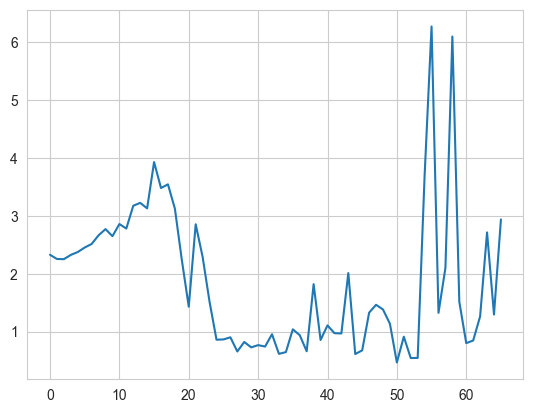

In [63]:
sns.lineplot(hist_val_loss_1)

<Axes: >

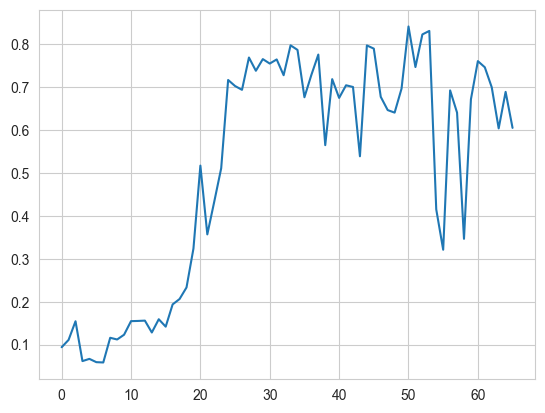

In [62]:
sns.lineplot(hist_val_acc_1)

In [48]:
hist_val_acc_1

[0.09259258955717087,
 0.11999999731779099,
 0.15753085911273956,
 0.09481481462717056,
 0.12469135969877243,
 0.09703703969717026,
 0.11802469193935394,
 0.09975308924913406,
 0.13629630208015442,
 0.1854320913553238,
 0.13283950090408325,
 0.12370370328426361,
 0.13679012656211853,
 0.14271605014801025,
 0.16469135880470276,
 0.14123456180095673,
 0.16790123283863068,
 0.19975309073925018,
 0.219506174325943,
 0.27975308895111084,
 0.3795061707496643,
 0.44864198565483093,
 0.5353086590766907,
 0.480246901512146,
 0.548395037651062,
 0.34839504957199097,
 0.4637036919593811,
 0.2812345623970032,
 0.3464197516441345,
 0.26148149371147156,
 0.37209877371788025,
 0.35185185074806213,
 0.42592594027519226,
 0.6691358089447021,
 0.7982715964317322,
 0.804444432258606,
 0.7674074172973633,
 0.7535802721977234,
 0.758765459060669,
 0.8207407593727112,
 0.6550617218017578,
 0.7432098984718323,
 0.590617299079895,
 0.4713580310344696,
 0.509876549243927,
 0.7508642077445984,
 0.80864197015762